<a href="https://colab.research.google.com/github/etomoscow/DL-in-NLP/blob/master/task3_sentiment_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.

In [0]:
import pandas as pd
import numpy as np
import torch, random, re

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [3]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

aclImdb_v1.tar.gz:   0%|          | 180k/84.1M [00:00<00:51, 1.61MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 69.4MB/s]


In [4]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.22 s, sys: 31.2 ms, total: 1.25 s
Wall time: 1.25 s


In [0]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [6]:
TEXT.vocab.freqs.most_common(10)

[('the', 225091),
 ('a', 111625),
 ('and', 111043),
 ('of', 100762),
 ('to', 93260),
 ('is', 72958),
 ('in', 63223),
 ('i', 49184),
 ('this', 48810),
 ('that', 46199)]

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=False,
        sort_key= lambda x: len(x[0]),# write your code here
        sort_within_batch=False,
        device='cuda',
        repeat=False
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [25]:
batch = next(train_iter.__iter__()); batch.text

tensor([[   10,     9,    10,  ...,  3215,     2,    10],
        [ 7086,    39,     7,  ..., 55230,  2370,    56],
        [ 1576,  2005,     3,  ...,   267,     5,    26],
        ...,
        [    1,     1, 94419,  ...,     1,     1,     1],
        [    1,     1,    13,  ...,     1,     1,     1],
        [    1,     1,   704,  ...,     1,     1,     1]], device='cuda:0')

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [26]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [0]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size

        self.encoder = nn.Embedding(vocab_size, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.1)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.sgm = nn.Sigmoid()

    def forward(self, seq):
        embs = self.encoder(seq.permute(1,0))
        out, hidden = self.gru(embs)
        out = self.decoder(hidden[-1])
        preds = self.sgm(out)
        return preds.squeeze(1)

In [29]:
em_sz = 200
nh = 300
model = RNNBaseline(hidden_dim = nh, emb_dim=em_sz, vocab_size=len(TEXT.vocab)); model

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNNBaseline(
  (encoder): Embedding(202316, 200)
  (gru): GRU(200, 300, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder): Linear(in_features=300, out_features=1, bias=True)
  (sgm): Sigmoid()
)

If you're using a GPU, remember to call model.cuda() to move your model to the GPU.

In [30]:
model.cuda()

RNNBaseline(
  (encoder): Embedding(202316, 200)
  (gru): GRU(200, 300, batch_first=True, dropout=0.1, bidirectional=True)
  (decoder): Linear(in_features=300, out_features=1, bias=True)
  (sgm): Sigmoid()
)

### The training loop (3 points)

Define the optimization and the loss functions.

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss(reduction='sum')

Define the stopping criteria.

In [0]:
epochs = 3

In [36]:
%%time
losses_train, losses_val = [], []
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for batch in train_iter: 
        
        x = batch.text
        y = batch.label
        opt.zero_grad()
        preds = model(x)   
        loss = loss_func(preds.to(dtype=torch.float32), y.to(dtype=torch.float32))
        loss.backward()
        opt.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trn)
    losses_train.append(epoch_loss)

    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        with torch.no_grad():    
            x = batch.text
            y = batch.label
        
            preds = model(x) 
            loss = loss_func(preds.to(dtype=torch.float32), y.to(dtype=torch.float32))
            val_loss += loss.item()
    val_loss /= len(vld)
    losses_val.append(val_loss)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, epoch_loss, val_loss))

Epoch: 1, Training Loss: 0.6654339932032994, Validation Loss: 0.5614567089080811
Epoch: 2, Training Loss: 0.40316899010794505, Validation Loss: 0.37331977961858115
Epoch: 3, Training Loss: 0.18278401768548147, Validation Loss: 0.48776236561139424
CPU times: user 1min 50s, sys: 36.1 s, total: 2min 26s
Wall time: 2min 27s


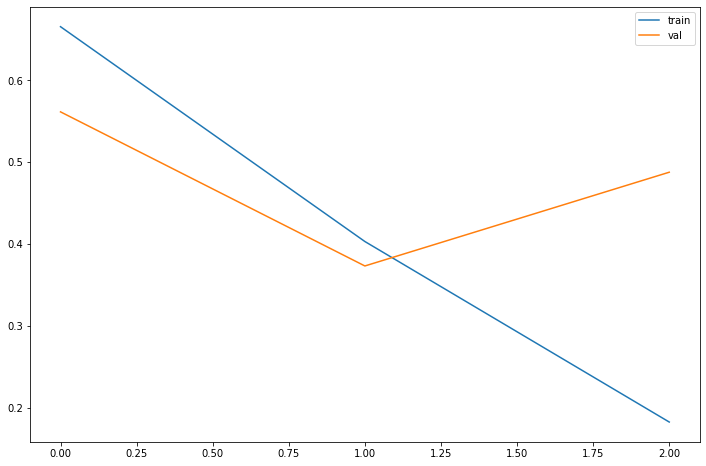

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend(loc='best')

### Calculate performance of the trained model (5 points)

In [0]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [47]:
for batch in test_iter:
    accuracies, rcl, precs, f1s = [], [], [], []
    model.eval()
    x = batch.text
    out = torch.round(model(x))
    out = out.detach().cpu().numpy()
    y = batch.label.to(torch.float32).detach().cpu().numpy()
    accuracies.append(accuracy_score(out,y))
    rcl.append(recall_score(out, y))
    precs.append(precision_score(out, y))
    f1s.append(f1_score(out, y))

print('Accuracy score:{}, recall:{}, f1-score:{}, precision:{}'.format(np.mean(accuracies), np.mean(rcl), np.mean(f1s), np.mean(precs)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Accuracy score:0.825, recall:1.0, f1-score:0.9041095890410958, precision:0.825


Write down the calculated performance

### Accuracy: 0.825
### Precision:0.825
### Recall: 0.825
### F1: 0.904

### Experiments (10 points)

Experiment with the model and achieve better results. You can find advices [here](https://arxiv.org/abs/1801.06146). Implement and describe your experiments in details, mention what was helpful.

### 1. First try: simple tuning: increased dropout in the 2-layer gru, added linear layer and activation function between them: accuracy score:0.925, recall:1.0, f1-score:0.96, precision:0.925
### 2. ?
### 3. ?

In [0]:
class RNN_2(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size

        self.encoder = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self.gru = nn.GRU(emb_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.5, num_layers=2)
        self.decoder_1 = nn.Linear(hidden_dim, 64)
        self.decoder_2 = nn.Linear(64, 1)
        self.act = nn.ReLU()
        self.sgm = nn.Sigmoid()

    def forward(self, seq):
        embs = self.encoder(seq.permute(1,0))
        out, hidden = self.gru(embs)
        out = self.act(self.decoder_1(hidden[-1]))
        out = self.decoder_2(out)
        preds = self.sgm(out)
        return preds.squeeze(1)

In [0]:
em_sz = 200
nh = 300
model = RNN_2(hidden_dim = nh, emb_dim=em_sz, vocab_size=len(TEXT.vocab)); model
model.cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss(reduction='sum')

Epoch: 1, Training Loss: 0.6560229925973075, Validation Loss: 0.558122517267863
Epoch: 2, Training Loss: 0.39326286370413643, Validation Loss: 0.3321685357411702
Epoch: 3, Training Loss: 0.17935112872804915, Validation Loss: 0.35293827832539876
CPU times: user 4min 49s, sys: 1min 53s, total: 6min 42s
Wall time: 6min 44s


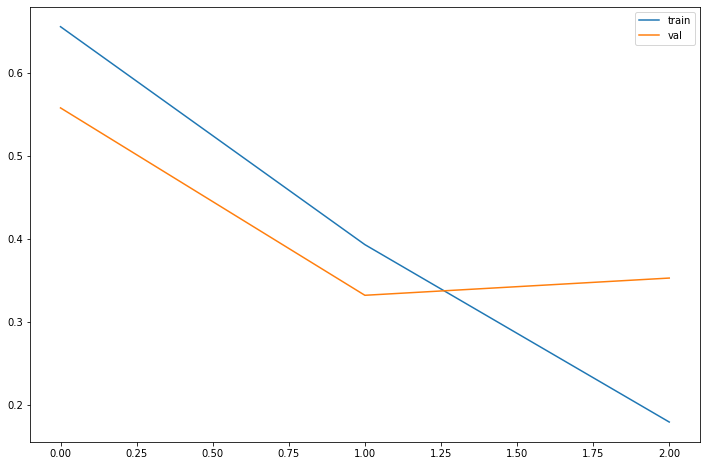

In [50]:
%%time
losses_train, losses_val = [], []
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for batch in train_iter: 
        
        x = batch.text
        y = batch.label
        opt.zero_grad()
        preds = model(x)   
        loss = loss_func(preds.to(dtype=torch.float32), y.to(dtype=torch.float32))
        loss.backward()
        opt.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trn)
    losses_train.append(epoch_loss)

    val_loss = 0.0
    model.eval()
    for batch in val_iter:
        with torch.no_grad():    
            x = batch.text
            y = batch.label
        
            preds = model(x) 
            loss = loss_func(preds.to(dtype=torch.float32), y.to(dtype=torch.float32))
            val_loss += loss.item()
    val_loss /= len(vld)
    losses_val.append(val_loss)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, epoch_loss, val_loss))

plt.figure(figsize=(12,8))
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend(loc='best')

In [51]:
for batch in test_iter:
    accuracies, rcl, precs, f1s = [], [], [], []
    model.eval()
    x = batch.text
    out = torch.round(model(x))
    out = out.detach().cpu().numpy()
    y = batch.label.to(torch.float32).detach().cpu().numpy()
    accuracies.append(accuracy_score(out,y))
    rcl.append(recall_score(out, y))
    precs.append(precision_score(out, y))
    f1s.append(f1_score(out, y))

print('Accuracy score:{}, recall:{}, f1-score:{}, precision:{}'.format(np.mean(accuracies), np.mean(rcl), np.mean(f1s), np.mean(precs)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score:0.925, recall:1.0, f1-score:0.961038961038961, precision:0.925


## Now let's try to rebuild our NN. 